# 2) c

In [8]:
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np

In [72]:
def barabasi(m, final_nodes):
    #m es el grado de los nodos iniciales y a la vez la cantidad de enlaces que agrego por iteracion
    
    new_node = m + 1 
        
    G = nx.complete_graph(m)
    G_dict = {key: m-1 for key in range(m)}
    
    for step in range(final_nodes - m):
        nodes_to_add = add_edges(G_dict, m)      
        G.add_node(new_node)
        G_dict[new_node] = m
        
         
        for node in nodes_to_add:
            G.add_edge(new_node, node)
            G_dict[node] += 1
                    
        new_node += 1
        
    return G


        
def add_edges(G_dict, m):
    nodes_probs = []
    nodes = list(G_dict.keys())
    total_degree = sum(G_dict.values())
    
    for node in nodes:
        node_degr = G_dict[node]
        node_prob = node_degr / total_degree
        nodes_probs.append(node_prob)
        

    random_nodes = np.random.choice(nodes, size = m, p = nodes_probs)
    
         
    return random_nodes
    
    
        
        
            


In [79]:
m_dict = {}

for _ in range(10):
    k_0 = np.random.randint(0,50)
    Network = barabasi(k_0, 10000)
    num_edges = Network.number_of_edges()
    diff = abs(num_edges - k_0 * 10000)
    diff_percent = diff / m * 100
    m_dict[k_0] = num_edges , diff, diff_percent
    print(m_dict[k_0])
       

(99433, 567, 0.4755713986160621)
(461224, 8776, 7.360872300272593)
(266667, 3333, 2.79555462361082)
(363941, 6059, 5.081987838121199)
(138949, 1051, 0.8815265254770391)
(207754, 2246, 1.88383308869784)
(99463, 537, 0.45040889075277835)
(335009, 4991, 4.1862025581883)
(138966, 1034, 0.8672677710211784)
(431996, 8004, 6.713357097924093)


# 3 (opcional)

In [138]:
"Esta funcion es la misma que el 2C, pero ahora guarda la informacion de los nodos agregados en el paso 5 y el paso 95"

def barabasi_mod(m, final_nodes):
    #m es el grado de los nodos iniciales y a la vez la cantidad de enlaces que agrego por iteracion
    
    node_5 = []
    node_95 = []
    new_node = m + 1 
        
    G = nx.complete_graph(m)
    G_dict = {key: m-1 for key in range(m)}
    
    for step in range(final_nodes - m):
        nodes_to_add = add_edges_mod(G_dict, m)      
        G.add_node(new_node)
        G_dict[new_node] = m
        
         
        for node in nodes_to_add:
            G.add_edge(new_node, node)
            G_dict[node] += 1
        
                
        if G_dict.get(m + 5):
            degree_5 = G_dict[m + 5]
            node_5.append(degree_5)
        
            
        if G_dict.get(m + 95):
            degree_95 = G_dict[m + 95]
            node_95.append(degree_95)
        
        

        new_node += 1
        
    return G,node_5, node_95


        
def add_edges_mod(G_dict, m):
    nodes_probs = []
    nodes = list(G_dict.keys())
    total_degree = sum(G_dict.values())
    
    for node in nodes:
        node_degr = G_dict[node]
        node_prob = node_degr / total_degree
        nodes_probs.append(node_prob)
        
    random_nodes = np.random.choice(nodes, size = m, p = nodes_probs)
    
         
    return random_nodes
    

In [124]:
Network_3, grado_5, grado_95 = barabasi_mod(7,10000)

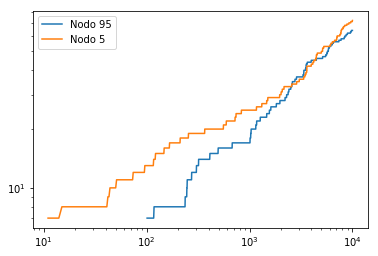

In [137]:
plt.loglog(list(range(6 + 95, 10000)),grado_95, label = "Nodo 95")
plt.loglog(list(range(6 + 5, 10000)), grado_5, label = "Nodo 5")
plt.legend()
plt.show()